In [1]:
import pandas as pd
import talib as ta
import numpy as np

In [2]:
def preprocess_stock_data(csv_file_path):
    # Load data from CSV file
    data = pd.read_csv(csv_file_path)
    data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
    data.set_index('Date', inplace=True)
    
    # Fill missing dates
    full_date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
    data = data.reindex(full_date_range)
    data = data.ffill()
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'Date'}, inplace=True)
    
    # Convert volume from string to number
    def convert_volume_to_number(volume_str):
        if isinstance(volume_str, float) and np.isnan(volume_str):
            return np.nan
        if volume_str[-1] == 'K':
            return int(float(volume_str[:-1]) * 1000)
        elif volume_str[-1] == 'M':
            return int(float(volume_str[:-1]) * 1000000)
        elif volume_str[-1] == 'B':
            return int(float(volume_str[:-1]) * 1000000000)
        else:
            return int(volume_str)
    
    # Apply convert_volume_to_number function to Volume column
    data["Volume"] = data["Volume"].apply(convert_volume_to_number)
    
    # Convert change % from string to number
    def convert_change_to_number(change_str):
        if isinstance(change_str, float) and np.isnan(change_str):
            return np.nan
        new_change = float(change_str.strip('%')) / 100
        return new_change

    # Apply convert_change_to_number function to Change % column
    data["Change %"] = data["Change %"].apply(convert_change_to_number)
    
    # Function to convert string to number
    def convert_str_to_number(str_value):
        if isinstance(str_value, float) and np.isnan(str_value):
            return np.nan
        return float(str_value.replace(',', ''))
    
    # Apply convert_str_to_number function to Close, Open, High, Low columns
    data['Close'] = data['Close'].apply(convert_str_to_number)
    data['Open'] = data['Open'].apply(convert_str_to_number)
    data['High'] = data['High'].apply(convert_str_to_number)
    data['Low'] = data['Low'].apply(convert_str_to_number)
    
    data = data.sort_values('Date', ascending=True)
    return data



In [3]:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(time_series):
    result = adfuller(time_series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] < 0.05:
        print("The series is stationary (reject the null hypothesis of unit root).")
    else:
        print("The series is non-stationary (fail to reject the null hypothesis of unit root).")


In [4]:
def difference_series(series):
    return series.diff()

In [5]:
import matplotlib.pyplot as plt
def plot_stock_data(stock_data, title):
    plt.figure(figsize=(12, 6))
    plt.plot(stock_data['Date'], stock_data['Close'], label='Close Price')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

In [6]:
def split_data(data, train_size=0.8, test_size=0.15):
    train_size = int(train_size * len(data))
    test_size = int(test_size * len(data))
    train_data = data[:train_size]
    test_data = data[train_size:train_size+test_size]
    validation_data = data[train_size+test_size:]
    return train_data, test_data, validation_data

In [7]:
import pandas as pd
import talib

def compute_technical_indicators(data):
    # Ensure the input is a pandas DataFrame
    if not isinstance(data, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame")
    
    # Get a list of columns that are not of type 'datetime' and not of type 'object'
    cols = data.select_dtypes(exclude=['datetime', 'object']).columns

    # Convert these columns to type 'double'
    data[cols] = data[cols].astype('double')

    # Compute Technical Indicators
    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    data['EMA_20'] = talib.EMA(data['Close'].values, timeperiod=20)
    data['RSI'] = talib.RSI(data['Close'].values, timeperiod=14)
    macd, macdsignal, macdhist = talib.MACD(data['Close'].values, fastperiod=12, slowperiod=26, signalperiod=9)
    data['MACD'] = macd
    data['MACD_Signal'] = macdsignal
    data['MACD_Diff'] = macdhist
    upper, middle, lower = talib.BBANDS(data['Close'].values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    data['BB_High'] = upper
    data['BB_Middle'] = middle
    data['BB_Low'] = lower
    data['ATR'] = talib.ATR(data['High'].values, data['Low'].values, data['Close'].values, timeperiod=14)
    data['OBV'] = talib.OBV(data['Close'].values, data['Volume'].values)
    
    # Drop rows with NaN values created by the indicators
    data.dropna(inplace=True)
    
    return data

In [8]:
# Load and preprocess data for multiple stocks
data = preprocess_stock_data('../../DATASET/DXG.csv')


In [9]:
# Compute technical indicators
data = compute_technical_indicators(data)


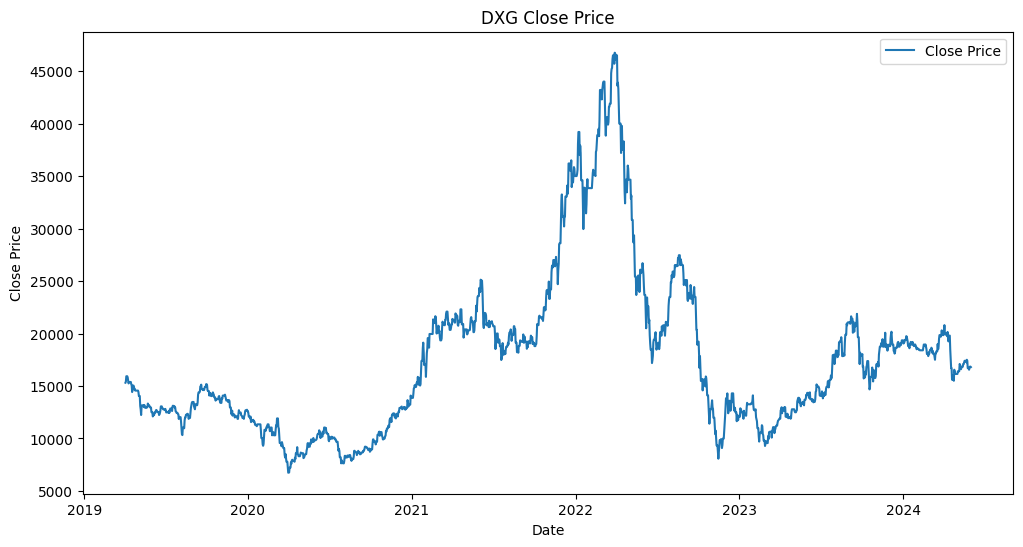

In [10]:
# Plot stock data
plot_stock_data(data, 'DXG Close Price')


In [11]:
dxg_train, dxg_test, dxg_validation = split_data(data)


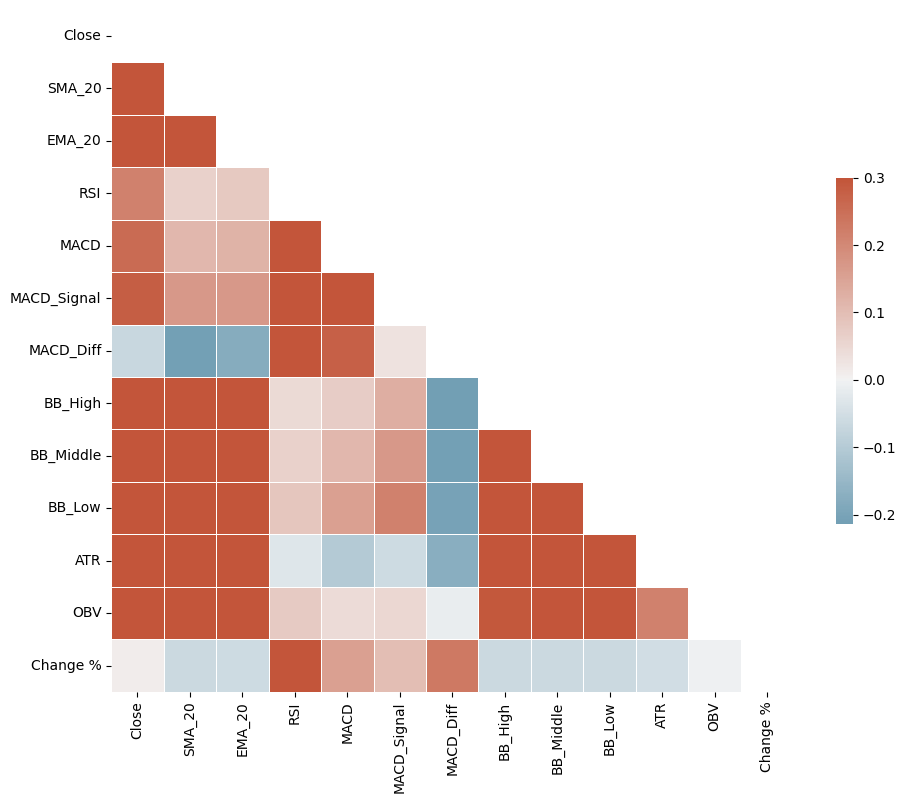

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select 'Close' and the technical indicators
selected_data = data[['Close', 'SMA_20', 'EMA_20', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff', 'BB_High', 'BB_Middle', 'BB_Low', 'ATR', 'OBV', 'Change %']]

# Compute the correlation matrix
corr = selected_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

Choose 'SMA_20', 'MACD_Signal', 'BB_High'(SMA_20 là 1), 'RSI' (MACD_Signal là 1), 'ATR' (là SMA_20)

In [13]:
# Check stationarity of DXG training sets
print("DXG Train Set Stationarity Check:")
check_stationarity(dxg_train['Close'])
check_stationarity(dxg_train['SMA_20'])
check_stationarity(dxg_train['MACD_Signal'])

DXG Train Set Stationarity Check:
ADF Statistic: -1.578364
p-value: 0.494452
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
The series is non-stationary (fail to reject the null hypothesis of unit root).
ADF Statistic: -2.741509
p-value: 0.067127
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
The series is non-stationary (fail to reject the null hypothesis of unit root).
ADF Statistic: -4.456820
p-value: 0.000235
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
The series is stationary (reject the null hypothesis of unit root).


In [14]:
# Apply differencing to make the training sets stationary
dxg_train['Close_diff'] = difference_series(dxg_train['Close'])
dxg_train['SMA_20_diff'] = difference_series(dxg_train['SMA_20'])

# Drop the first NaN value generated by differencing
dxg_train.dropna(inplace=True)


/var/folders/6_/q31jqlzd6195rlvq5qgn5qn80000gn/T/ipykernel_47139/1874695050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dxg_train['Close_diff'] = difference_series(dxg_train['Close'])
/var/folders/6_/q31jqlzd6195rlvq5qgn5qn80000gn/T/ipykernel_47139/1874695050.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dxg_train['SMA_20_diff'] = difference_series(dxg_train['SMA_20'])
/var/folders/6_/q31jqlzd6195rlvq5qgn5qn80000gn/T/ipykernel_47139/1874695050.py:6: SettingWithCopyWarning: 
A value is trying t

In [15]:
# Recheck if the DXG training sets are now stationary
print("DXG Train Set Stationarity Check:")
check_stationarity(dxg_train['Close_diff'])
check_stationarity(dxg_train['SMA_20_diff'])


DXG Train Set Stationarity Check:
ADF Statistic: -15.255471
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
The series is stationary (reject the null hypothesis of unit root).
ADF Statistic: -3.810693
p-value: 0.002800
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568
The series is stationary (reject the null hypothesis of unit root).


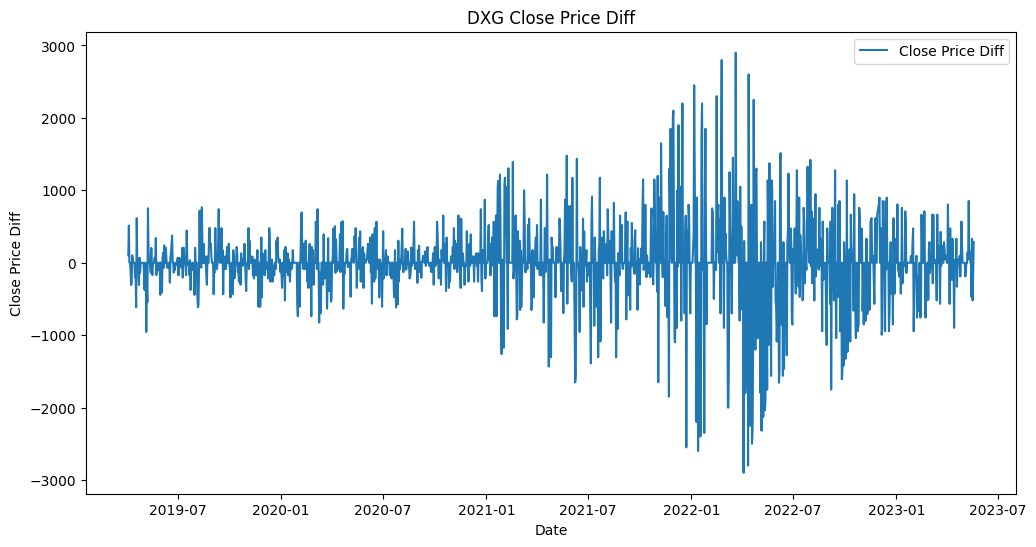

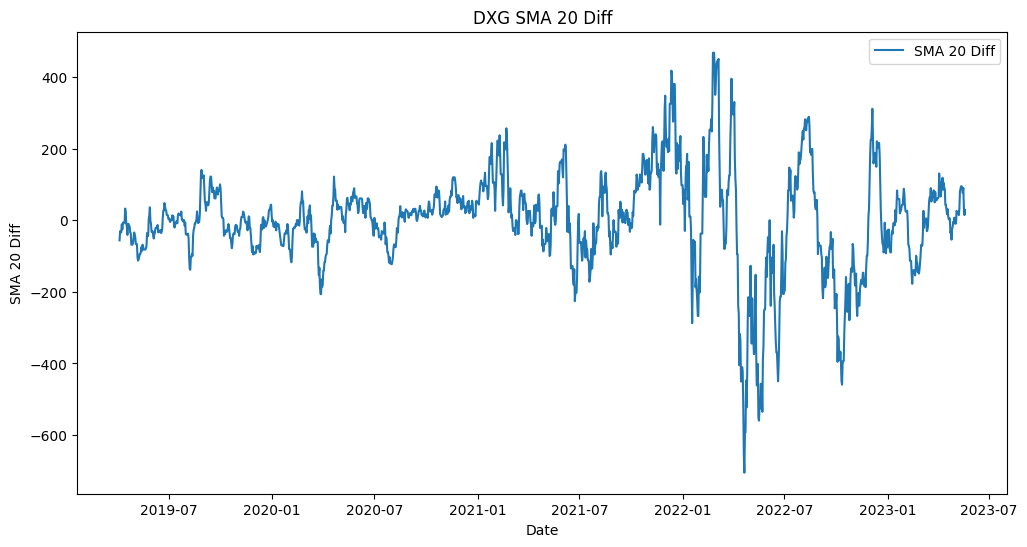

In [16]:
# Plot line chart of DXG close diff
plt.figure(figsize=(12, 6))
plt.plot(dxg_train['Date'], dxg_train['Close_diff'], label='Close Price Diff')
plt.title('DXG Close Price Diff')
plt.xlabel('Date')
plt.ylabel('Close Price Diff')
plt.legend()
plt.show()
# Plot line chart of DXG SMA 20 diff
plt.figure(figsize=(12, 6))
plt.plot(dxg_train['Date'], dxg_train['SMA_20_diff'], label='SMA 20 Diff')
plt.title('DXG SMA 20 Diff')
plt.xlabel('Date')
plt.ylabel('SMA 20 Diff')
plt.legend()
plt.show()

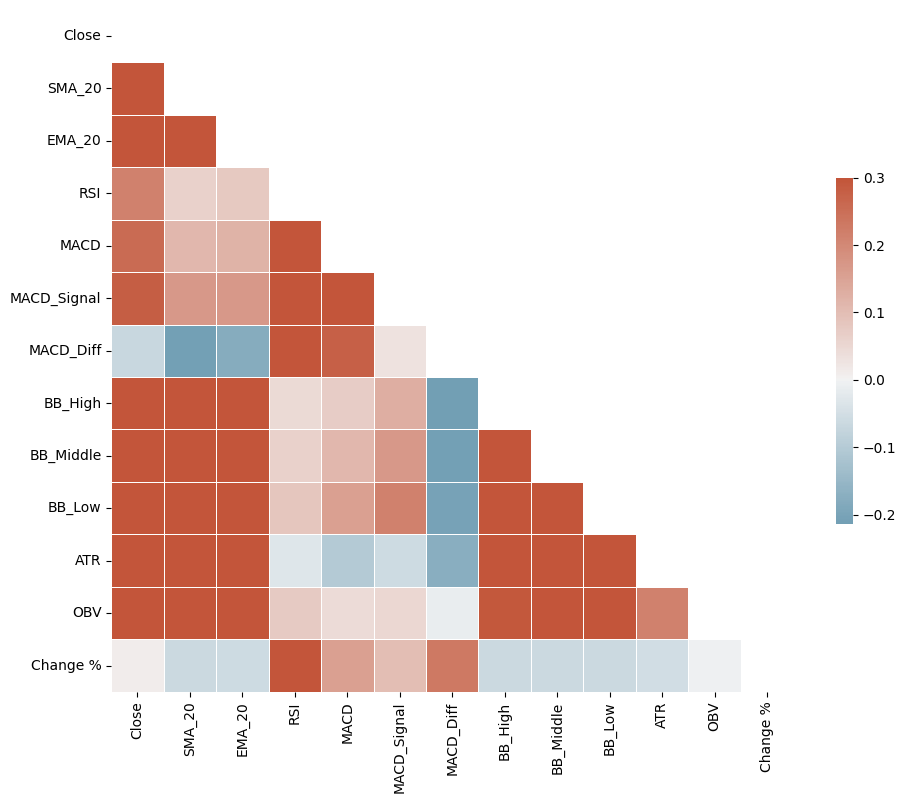

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select 'Close' and the technical indicators
selected_data = data[['Close', 'SMA_20', 'EMA_20', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Diff', 'BB_High', 'BB_Middle', 'BB_Low', 'ATR', 'OBV', 'Change %']]

# Compute the correlation matrix
corr = selected_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [19]:
endog_train, endog_test, endog_validation = dxg_train['Close'], dxg_test['Close'], dxg_validation['Close']
exog_train = dxg_train[['SMA_20', 'MACD_Signal']]
exog_test = dxg_test[['SMA_20', 'MACD_Signal']]
exog_validation = dxg_validation[['SMA_20', 'MACD_Signal']]
exog_train

,SMA_20,MACD_Signal
34,15564.005,-551.364718
35,15533.240,-517.824993
36,15502.475,-478.650095
37,15468.290,-436.905852
38,15456.325,-396.380622
...,...,...
1536,12941.700,297.594385
1537,13031.650,316.130837
1538,13067.150,322.832712
1539,13081.350,318.764254


In [20]:
# import the StandardScaler class
from sklearn.preprocessing import StandardScaler
# Scale the Exogenous Variables
scaler = StandardScaler()
exog_train_scaled = scaler.fit_transform(exog_train)
exog_test_scaled = scaler.transform(exog_test)
exog_validation_scaled = scaler.transform(exog_validation)

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
dxg_train

,Date,Close,Open,High,Low,Volume,Change %,SMA_20,EMA_20,RSI,MACD,MACD_Signal,MACD_Diff,BB_High,BB_Middle,BB_Low,ATR,OBV,Close_diff,SMA_20_diff
34,2019-04-04,15417.0,15451.2,15553.7,15314.5,1070000.0,0.0067,15564.005,15639.360789,41.226760,-456.857031,-551.364718,94.507687,16583.627615,15564.005,14544.382385,378.858107,-7641840.0,102.5,-56.405
35,2019-04-05,15929.8,15451.2,16066.5,15417.0,1840000.0,0.0333,15533.240,15667.021666,52.519732,-383.666093,-517.824993,134.158900,16466.029394,15533.240,14600.450606,398.189671,-5801840.0,512.8,-30.765
36,2019-04-06,15929.8,15451.2,16066.5,15417.0,1840000.0,0.0333,15502.475,15692.048174,52.519732,-321.950503,-478.650095,156.699592,16334.935178,15502.475,14670.014822,416.140409,-5801840.0,0.0,-30.765
37,2019-04-07,15929.8,15451.2,16066.5,15417.0,1840000.0,0.0333,15468.290,15714.691205,52.519732,-269.928880,-436.905852,166.976972,16159.637605,15468.290,14776.942395,432.808951,-5801840.0,0.0,-34.185
38,2019-04-08,15827.2,16066.5,16066.5,15724.7,875800.0,-0.0064,15456.325,15725.406328,50.113504,-234.279702,-396.380622,162.100920,16113.273326,15456.325,14799.376674,426.308312,-6677640.0,-102.6,-11.965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1536,2023-05-15,13399.0,14014.0,14014.0,13399.0,21670000.0,-0.0341,12941.700,13043.522915,61.938248,383.419475,297.594385,85.825090,14038.815874,12941.700,11844.584126,485.184175,534020132.0,-473.0,75.750
1537,2023-05-16,13730.0,13446.0,13730.0,13351.0,18410000.0,0.0247,13031.650,13108.901685,66.997957,390.276642,316.130837,74.145805,14076.293341,13031.650,11987.006659,477.599591,552430132.0,331.0,89.950
1538,2023-05-17,13209.0,13777.0,14109.0,13209.0,27420000.0,-0.0379,13067.150,13118.434858,54.677199,349.640215,322.832712,26.807503,14084.885776,13067.150,12049.414224,507.771048,525010132.0,-521.0,35.500
1539,2023-05-18,13067.0,13304.0,13446.0,13020.0,18420000.0,-0.0108,13081.350,13113.536300,51.877018,302.490420,318.764254,-16.273834,14090.721740,13081.350,12071.978260,501.930259,506590132.0,-142.0,14.200


In [22]:
# endog_data = dxg_train['Close']
# # exog_data = dxg_train['SMA20', 'MACD_Signal']
# exog_data = dxg_train[['SMA_20', 'MACD_Signal']]
# endog_data
# # exog_data

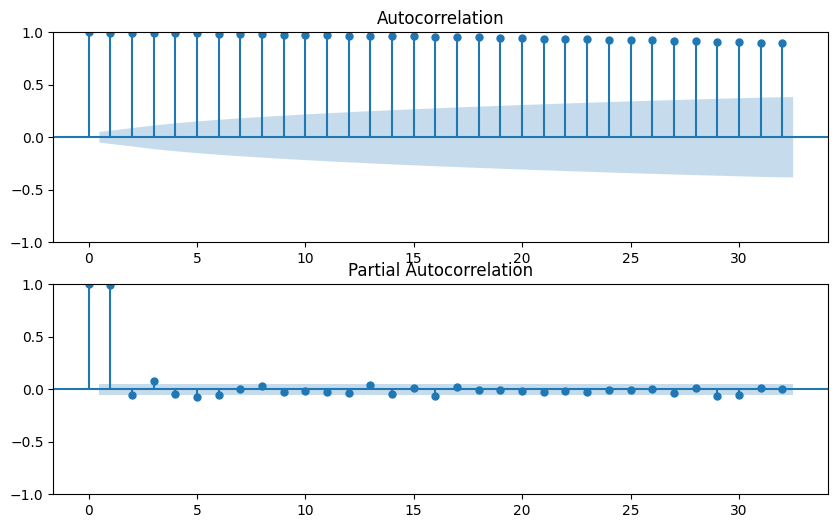

In [23]:
plt.figure(figsize=(10, 6))
ax1 = plt.subplot(211)
plot_acf(endog_train, ax=ax1)
ax2 = plt.subplot(212)
plot_pacf(endog_train, ax=ax2)
plt.show()

In [24]:
import itertools
import statsmodels.api as sm

p = d = q = range(0, 3)  
pdq = list(itertools.product(p, d, q))
best_aic = np.inf
best_pdq = None
best_model = None

for param in pdq:
    try:
        model = sm.tsa.ARIMA(endog=endog_train, exog=exog_train, order=param)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_model = results
    except:
        continue

print(f"Best ARIMAX Model: {best_pdq} with AIC: {best_aic}")

/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packag

Best ARIMAX Model: (2, 0, 2) with AIC: 23098.004769677835


/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [25]:
model = sm.tsa.ARIMA(endog_train, exog=exog_train_scaled, order=best_pdq)
model_fit = model.fit()


/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [26]:
# Forecasting
forecast_test = model_fit.forecast(steps=len(endog_test), exog=exog_test_scaled)
forecast_validation = model_fit.forecast(steps=len(endog_validation), exog=exog_validation_scaled)


/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


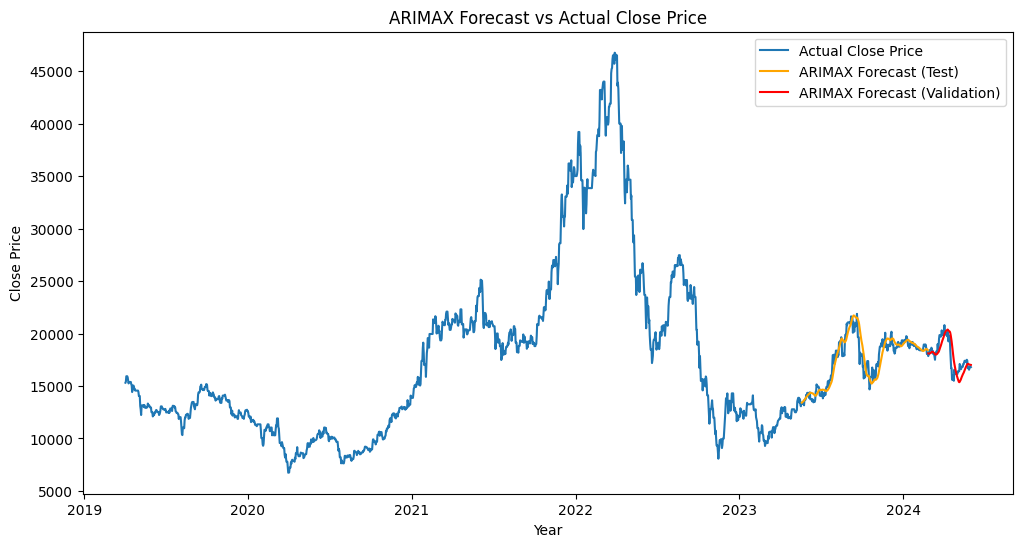

In [27]:
# Plot the results
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(data['Date'], data['Close'], label='Actual Close Price')
ax.plot(dxg_test['Date'], forecast_test, label='ARIMAX Forecast (Test)', color='orange')
ax.plot(dxg_validation['Date'], forecast_validation, label='ARIMAX Forecast (Validation)', color='red')
ax.set_title('ARIMAX Forecast vs Actual Close Price')
ax.set_xlabel('Year')
ax.set_ylabel('Close Price')
plt.legend()
plt.show()

/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/willphan_43/.pye

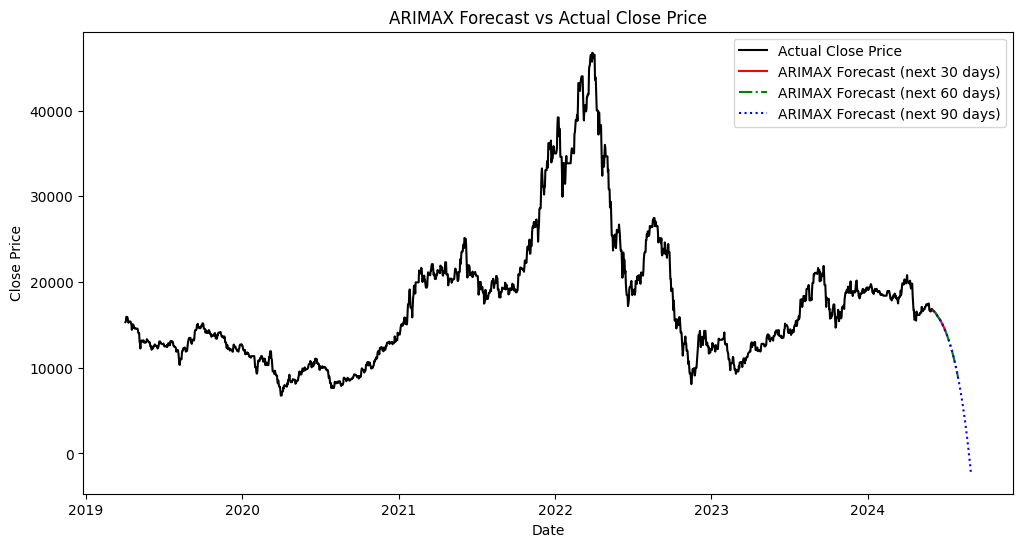

In [28]:
def predict_and_update(data, model_fit, scaler, steps):
    predictions = []
    future_dates = pd.date_range(start=data['Date'].iloc[-1], periods=steps+1, freq='D')[1:]
    
    for _ in range(steps):
        exog = scaler.transform(data[['SMA_20', 'MACD_Signal']].iloc[-1:].values.reshape(1, -1))
        forecast = model_fit.forecast(steps=1, exog=exog)
        
        if isinstance(forecast, np.ndarray) or isinstance(forecast, list):
            forecast_value = forecast[0]
        elif isinstance(forecast, pd.Series) or isinstance(forecast, pd.DataFrame):
            forecast_value = forecast.iloc[0]
        else:
            raise ValueError("Unsupported forecast return type")
        
        predictions.append(forecast_value)
        
        new_row = pd.DataFrame({'Date': [future_dates[_]], 'Close': [forecast_value]})
        data = pd.concat([data, new_row], ignore_index=True)
        
        data["SMA_20"] = data['Close'].rolling(window=20).mean()
        macd, macdsignal, macdhist = ta.MACD(data['Close'].values, fastperiod=12, slowperiod=26, signalperiod=9)
        data['MACD'] = macd
        data['MACD_Signal'] = macdsignal
        data['MACD_Diff'] = macdhist
    
    return future_dates, predictions

def plot_forecasts(data, forecasts, labels, colors, styles):
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(data['Date'], data['Close'], label='Actual Close Price', color='black', linestyle='-')
    
    for forecast, label, color, style in zip(forecasts, labels, colors, styles):
        ax.plot(forecast[0], forecast[1], label=label, color=color, linestyle=style)
    
    ax.set_title('ARIMAX Forecast vs Actual Close Price')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')
    plt.legend()
    plt.show()

scaler = StandardScaler()
scaler.fit(data[['SMA_20', 'MACD_Signal']])

# Predict and plot
forecasts = []
labels = ['ARIMAX Forecast (next 30 days)', 'ARIMAX Forecast (next 60 days)', 'ARIMAX Forecast (next 90 days)']
colors = ['red', 'green', 'blue']

# Generate 90-day forecast first
if len(data) > 0:
    future_dates_90, predictions_90 = predict_and_update(data.copy(), model_fit, scaler, 90)
    forecasts.append((future_dates_90[:30], predictions_90[:30]))  # 30-day forecast
    forecasts.append((future_dates_90[:60], predictions_90[:60]))  # 60-day forecast
    forecasts.append((future_dates_90, predictions_90))  # 90-day forecast
styles = ['-', '-.', ':']
plot_forecasts(data, forecasts, labels, colors, styles)

In [29]:
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Assuming `model_fit` is your fitted model and `exog_test` is your test set for exogenous variables
predictions = model_fit.predict(start=len(endog_train), end=len(endog_train) + len(endog_test) - 1, exog=exog_test)

# Calculate RMSE
# Valid rmse
rmse = np.sqrt(mean_squared_error(endog_validation, forecast_validation))
print(f'Validation RMSE: {rmse}')
# Test rmse
rmse = np.sqrt(mean_squared_error(endog_test, forecast_test))
print(f'Testing RMSE: {rmse}')


# Calculate MDA without relying on indices
# Valid mda
valid_mda = np.mean((np.sign(np.diff(endog_validation.values)) == np.sign(np.diff(predictions[:len(endog_validation)].values))).astype(int))
print(f'Validation Mean Directional Accuracy: {valid_mda}')
# Test mda
test_mda = np.mean((np.sign(np.diff(endog_test.values)) == np.sign(np.diff(predictions[-len(endog_test):].values))).astype(int))
print(f'Testing Mean Directional Accuracy: {test_mda}')
# Calculate MAPE
# Valid mape
mape = np.mean(np.abs((endog_validation - forecast_validation) / endog_validation)) * 100
print(f'Validation Mean Absolute Percentage Error: {mape}')
# Test mape
mape = np.mean(np.abs((endog_test - predictions) / endog_test)) * 100
print(f'Testing Mean Absolute Percentage Error: {mape}')


Validation RMSE: 983.2678698691647
Testing RMSE: 806.0737749225235
Validation Mean Directional Accuracy: 0.3263157894736842
Testing Mean Directional Accuracy: 0.39501779359430605
Validation Mean Absolute Percentage Error: nan
Testing Mean Absolute Percentage Error: 858854.9017106098


/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/willphan_43/.pyenv/versions/3.11.3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
